In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
c = 299792458 #speed of light m s^-1

plt.rcParams['figure.figsize'] = [20, 10]


from datetime import datetime


In [2]:
cwd = os.getcwd()
filters_folder = cwd + "/" + "Filters"
template_file = cwd + "/" + "Templates" + "/" + "ARP220_loglam_lognuLnu.txt"
files = os.listdir(filters_folder)
Filters = []
for item in files:
    if item[len(item)-3:len(item)] == "dat":
        Filters.append(item[0:len(item)-4])

In [3]:
Filters

['Herschel_Pacs.red',
 'Paranal_HAWKI.Ks',
 'Spitzer_IRAC.I4',
 'HST_ACS_HRC.F814W',
 'Spitzer_IRAC.I3',
 'Herschel_Pacs.blue',
 'Spitzer_IRAC.I2',
 'HST_WFC3_IR.F105W',
 'HST_WFC3_IR.F125W',
 'HST_ACS_HRC.F435W',
 'Spitzer_IRAC.I1',
 'Spitzer_MIPS.24mu',
 'Herschel_SPIRE.PMW',
 'Herschel_Pacs.green',
 'Herschel_SPIRE.PLW',
 'Herschel_SPIRE.PSW',
 'HST_WFC3_IR.F160W',
 'HST_WFC3_IR.F140W',
 'HST_ACS_HRC.F606W']

In [4]:
params = {}
params["Template"] = template_file
params["Filters"] = {}
params["Filters_Folder"] = filters_folder
for item in Filters:
    params["Filters"][item] = {}
    params["Filters"][item]["filename"] = filters_folder +"/"+ item + ".dat"

In [5]:
filters_folder

'/Users/cv/sed_research/Filters'

In [6]:
params

{'Filters': {'HST_ACS_HRC.F435W': {'filename': '/Users/cv/sed_research/Filters/HST_ACS_HRC.F435W.dat'},
  'HST_ACS_HRC.F606W': {'filename': '/Users/cv/sed_research/Filters/HST_ACS_HRC.F606W.dat'},
  'HST_ACS_HRC.F814W': {'filename': '/Users/cv/sed_research/Filters/HST_ACS_HRC.F814W.dat'},
  'HST_WFC3_IR.F105W': {'filename': '/Users/cv/sed_research/Filters/HST_WFC3_IR.F105W.dat'},
  'HST_WFC3_IR.F125W': {'filename': '/Users/cv/sed_research/Filters/HST_WFC3_IR.F125W.dat'},
  'HST_WFC3_IR.F140W': {'filename': '/Users/cv/sed_research/Filters/HST_WFC3_IR.F140W.dat'},
  'HST_WFC3_IR.F160W': {'filename': '/Users/cv/sed_research/Filters/HST_WFC3_IR.F160W.dat'},
  'Herschel_Pacs.blue': {'filename': '/Users/cv/sed_research/Filters/Herschel_Pacs.blue.dat'},
  'Herschel_Pacs.green': {'filename': '/Users/cv/sed_research/Filters/Herschel_Pacs.green.dat'},
  'Herschel_Pacs.red': {'filename': '/Users/cv/sed_research/Filters/Herschel_Pacs.red.dat'},
  'Herschel_SPIRE.PLW': {'filename': '/Users/cv/sed_r

In [32]:
class sed(object):
    def __init__(self,params):
        self.filters = params.get("Filters")
        template = params.get("Template")
        self.loglam,self.lognuLnu = np.loadtxt(template,usecols=(0,1), delimiter=" ", unpack=True)
        self.nuLnu = np.power(10.,self.lognuLnu)
        self.lam = np.power(10.,self.loglam)
        #self.ilognuLnu = interp1d(self.loglam,self.lognuLnu)
        #loading filters
        for Filter in self.filters:
            lam,trans = np.loadtxt(self.filters[Filter]["filename"],usecols =(0,1),delimiter=" ",unpack=True)
            #Pass wavelength from Angstrom to microns
            self.filters[Filter]["lam"] = lam*1e-4
            self.filters[Filter]["trans"] = trans
        #For Filters Photometry
        self.phot = []
        self.lam_eff = []
        self.labels = []
    def redshift(self,z):
        #Applying a redshift
        self.z = z
        self.nuFnu = self.nuLnu/(4*np.pi*Planck15.luminosity_distance(z).value**2)
        self.lam_new = self.lam*(1.+z)
        #Interpolated nuFnu
        self.inuFnu = interp1d(self.lam_new,self.nuFnu)
    def photometry(self):
        #Gets the photometry of all the filters
        for Filter in self.filters:
            lam = self.filters[Filter]["lam"]
            trans = self.filters[Filter]["trans"]
            nuFnu = self.inuFnu(lam)
            #Doing the integral for photometry - effective stimulus
            phot = np.trapz(nuFnu*trans*lam,lam)/np.trapz(trans*lam,lam)
            self.phot.append(phot)
            #Doing the integral for effective wavelength
            lam_eff = np.trapz(nuFnu*trans*lam*lam,lam)/np.trapz(nuFnu*trans*lam,lam)
            self.lam_eff.append(lam_eff)
            self.labels.append(self.filters[Filter])
    def plot_sed(self,color="blue"):
        #Plotting the SED and the possible Photometry
        #plt.title("mysed; z={}".format(self.z))
        plt.ylabel("$\\nu F_\\nu$ [($10^{-10}$ $ergs$ $s^{-1}$ $cm^{-2}$]")
        plt.xlabel("$\lambda$ [$\mu$m]")
        plt.loglog(self.lam_new,self.inuFnu(self.lam_new),color=color,label="{}".format(self.z))
        #plt.loglog()
    def plot_filters(self,norm):
        for Filter in self.filters:
            lam = mysed.filters[Filter]["lam"]
            trans = mysed.filters[Filter]["trans"]*norm
            plt.semilogx(lam,trans,label = Filter)

In [8]:
mysed = sed(params)
mysed.redshift(1.)
Filter = 'Herschel_Pacs.blue'
x = mysed.filters[Filter]["lam"]
y = mysed.filters[Filter]["trans"]


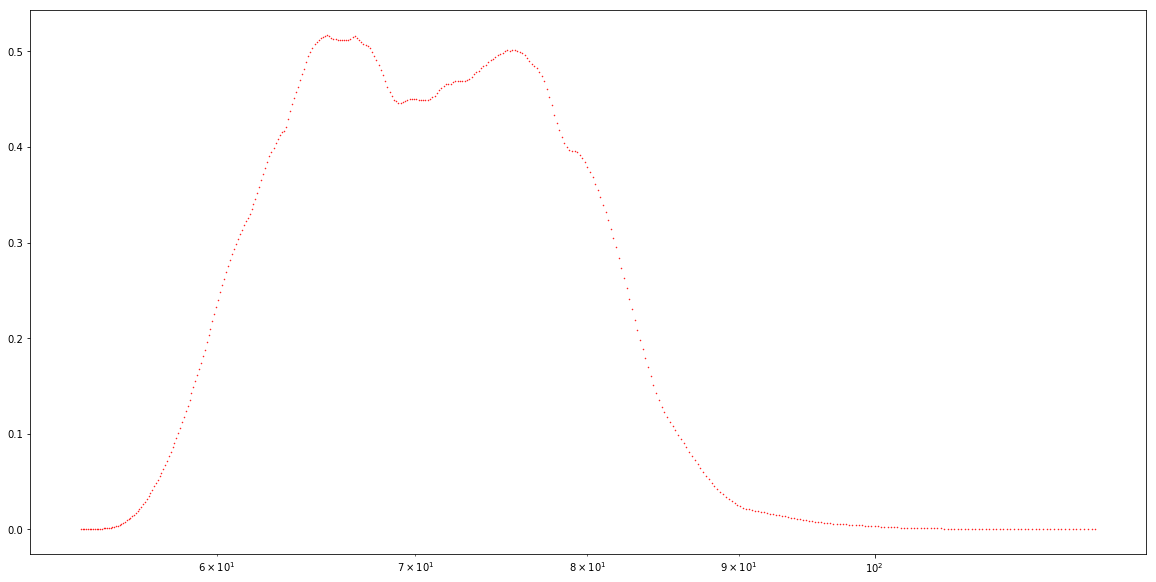

In [9]:
plt.semilogx(x,y,"ro",markersize = 0.5)
plt.show()

In [10]:
#Filter = 'HST_ACS_HRC.F814W'
lam = mysed.filters[Filter]["lam"]
trans = mysed.filters[Filter]["trans"]
trans = trans/np.trapz(trans,lam)
#P = np.trapz()
nuFnu = mysed.inuFnu(lam)
#Doing the integral for photometry - effective stimulus
phot = np.trapz(nuFnu*trans*lam,lam)/np.trapz(trans*lam,lam)
#self.phot.append(phot)
#Doing the integral for effective wavelength
lam_eff = np.trapz(nuFnu*trans*lam*lam,lam)/np.trapz(nuFnu*trans*lam,lam)
#self.lam_eff.append(lam_eff)
#self.labels.append(self.filters[Filter])

plt.loglog(lam,nuFnu)
plt.loglog(lam_eff,phot,"ro")
plt.loglog(lam,trans)
plt.loglog()
plt.show()

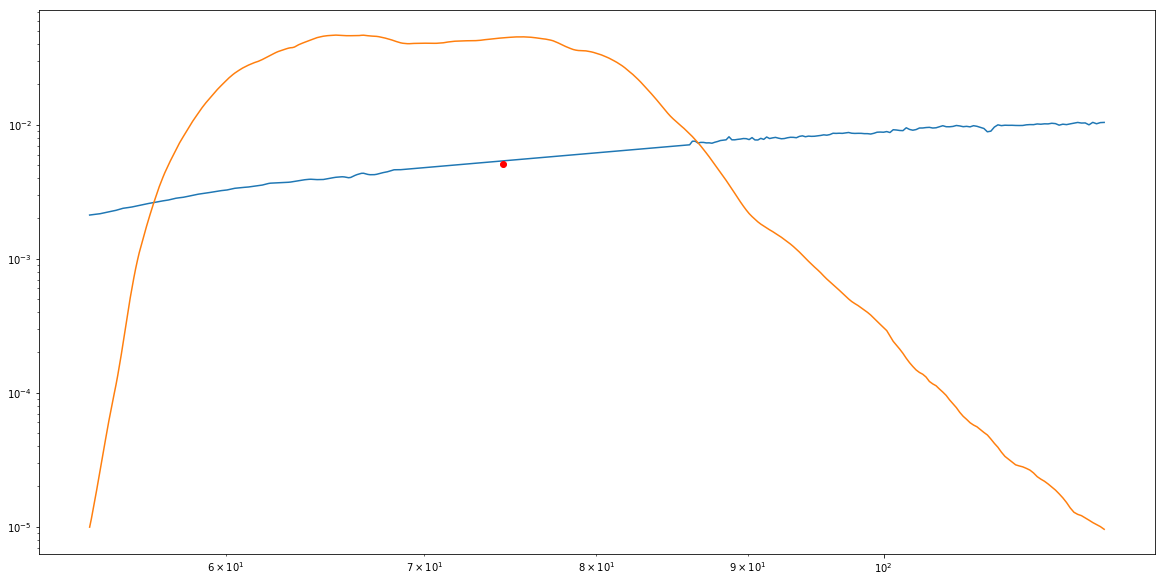

In [33]:
mysed = sed(params)

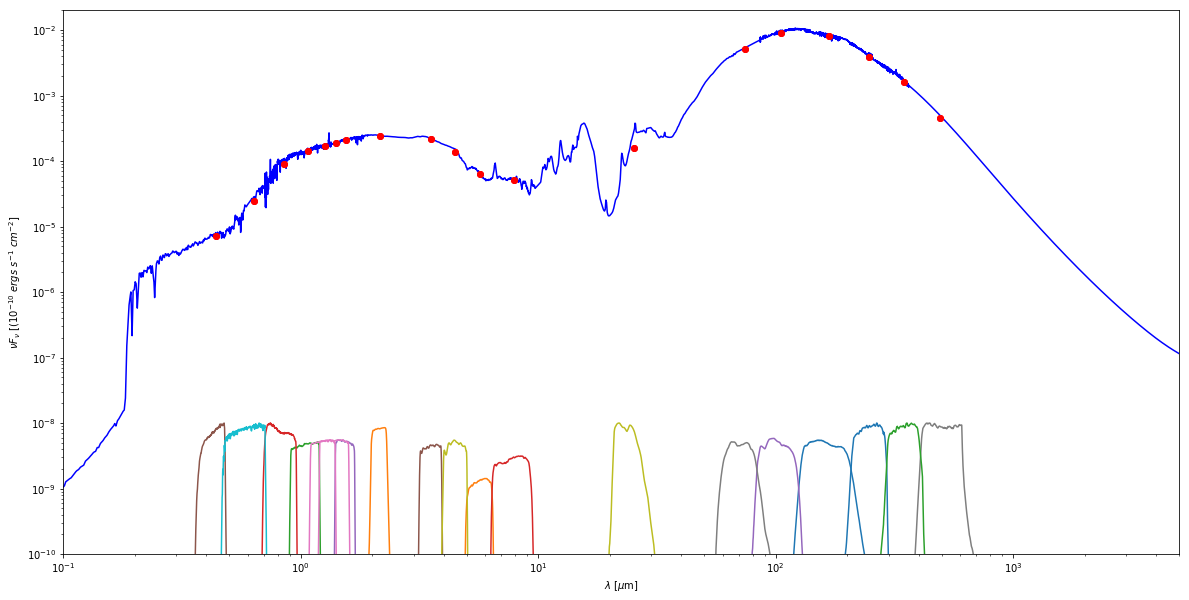

In [35]:

mysed.redshift(1.)
mysed.photometry()
mysed.plot_sed()
#plt.semilogx(x,y*1e-8,"ro",markersize = 0.5)
plt.loglog(mysed.lam_eff,mysed.phot,"ro")

mysed.plot_filters(1e-8)
plt.ylim(1e-10,2e-2)
plt.xlim(1e-1,5e3)
#plt.legend(loc="lower right")
plt.show()

In [42]:
mysed = sed(params)

0:00:00.212223
0:00:00.053663
0:00:00.055841


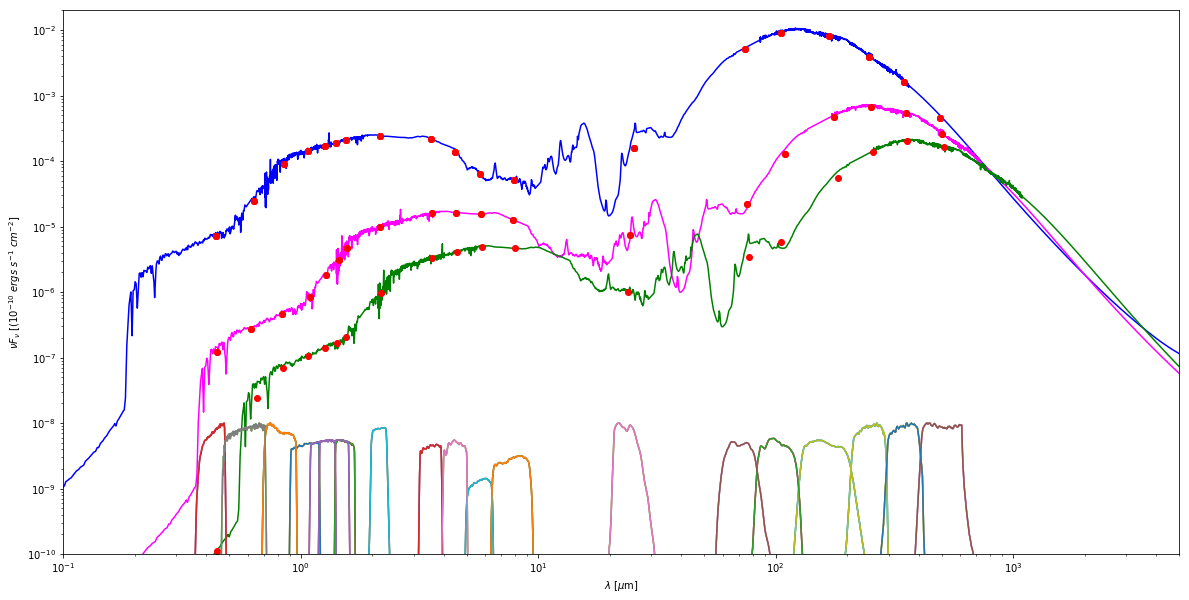

In [43]:
startTime = datetime.now()

mysed.redshift(1.)
mysed.plot_sed(color="blue")

mysed.photometry()
plt.loglog(mysed.lam_eff,mysed.phot,"ro")
mysed.plot_filters(1e-8)
plt.ylim(1e-10,2e-2)
plt.xlim(1e-1,5e3)

print datetime.now() - startTime

startTime = datetime.now()

mysed.redshift(3.)
mysed.plot_sed(color="magenta")

mysed.photometry()
plt.loglog(mysed.lam_eff,mysed.phot,"ro")
mysed.plot_filters(1e-8)
plt.ylim(1e-10,2e-2)
plt.xlim(1e-1,5e3)

print datetime.now() - startTime

startTime = datetime.now()

mysed.redshift(5.)
mysed.plot_sed(color="green")

mysed.photometry()
plt.loglog(mysed.lam_eff,mysed.phot,"ro")
mysed.plot_filters(1e-8)
plt.ylim(1e-10,2e-2)
plt.xlim(1e-1,5e3)

print datetime.now() - startTime



#plt.legend()
plt.show()